## Import needed libraries

In [ ]:
import os
import time
import pathlib
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

2025-06-03 16:54:23.504775: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-03 16:54:23.504884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-03 16:54:23.653451: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Preprocessing

In [2]:
train_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis= 1)
data 

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [3]:
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing' 
filepaths = []
labels = []
folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir,fold)
    filelist = os.listdir(foldpath) 
    for file in filelist:
        fpath = os.path.join(foldpath,file)
        filepaths.append (fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths,name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')
dt = pd.concat([Fseries,Lseries],axis='columns')
dt 

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


In [4]:
train_df, valid_df = train_test_split(data, train_size=0.8, stratify=data['labels'], shuffle=True, random_state=123)

In [5]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

batch_size=16
img_size = (224,224)
channels = 3 
img_shape=(img_size[0],img_size[1],channels)  #224*224*3
tr_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=(0.85, 1.15),
)

ts_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)
test_gen = ts_gen.flow_from_dataframe( dt, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= False ,batch_size= batch_size)
valid_gen = valid_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)

Found 4569 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.


In [6]:
print(f"Total training images: {train_gen.samples}")
print(f"Total validation images: {valid_gen.samples}")
print(f"Total testing images: {test_gen.samples}")

Total training images: 4569
Total validation images: 1143
Total testing images: 1311


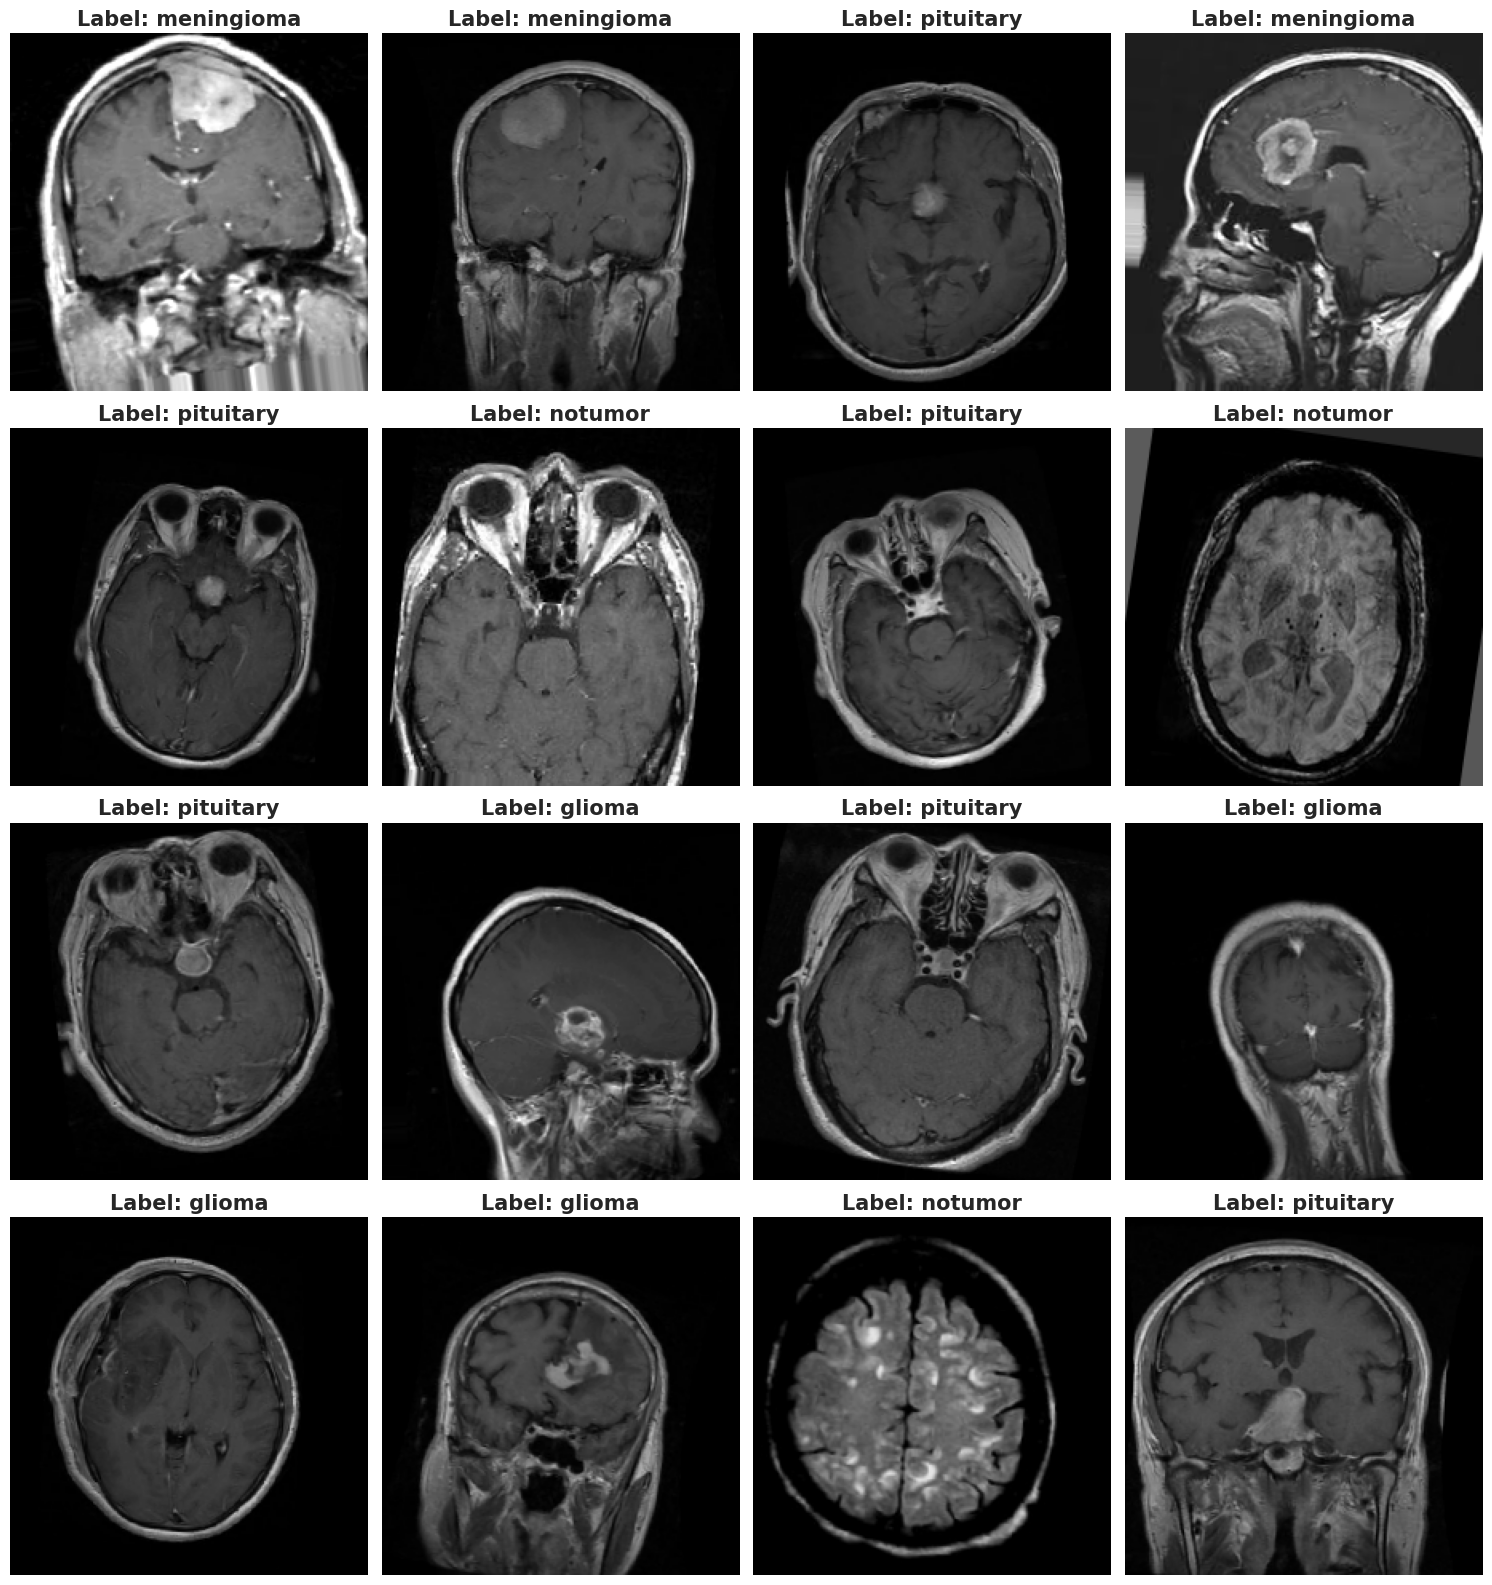

In [7]:
images, labels = next(train_gen)

images = (images + 1.0) * 127.5 
images = np.clip(images, 0, 255).astype('uint8') 

# Get class names
class_names = list(train_gen.class_indices.keys())

# Plot configuration
num_images = min(len(images), 16)  # Show up to 16 images
rows = 4
fig, axes = plt.subplots(rows, 4, figsize=(15, 4 * rows))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {class_names[np.argmax(labels[i])]}',
                     fontsize=15, fontweight='bold')
        ax.axis('off')

# Hide any empty subplots
for ax in axes.flat[num_images:]:
    ax.axis('off')

plt.tight_layout(pad=1)
plt.show()


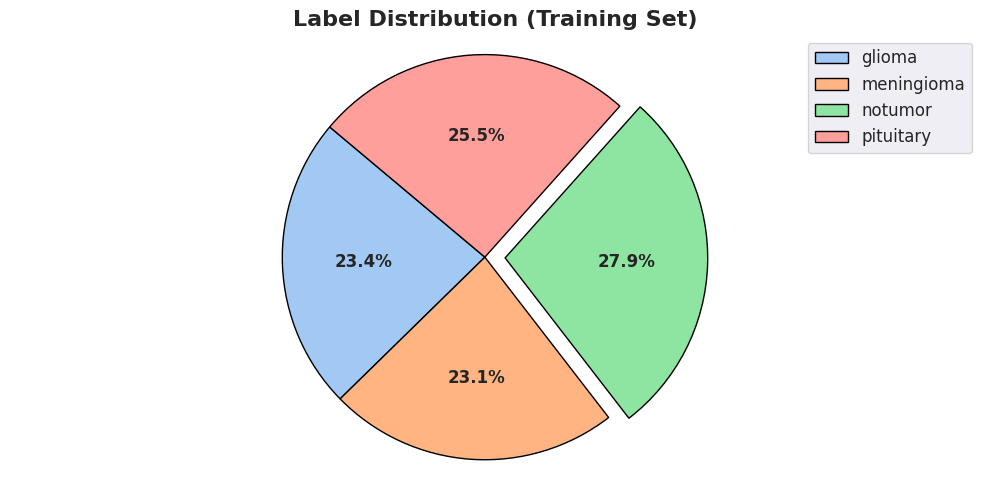

In [8]:
from collections import defaultdict

train_label_counts = defaultdict(int)
for label in train_df['labels']:
    train_label_counts[label] += 1

class_names = list(train_gen.class_indices.keys())
sizes_train = list(train_label_counts.values())

fig, ax = plt.subplots(figsize=(10, 5))
wedges_train, texts_train, autotexts_train = ax.pie(
    sizes_train,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel'),
    wedgeprops=dict(edgecolor='black'),
    explode=[0.1 if i == 2 else 0 for i in range(len(class_names))]  # Explode 3rd slice
)

ax.set_title('Label Distribution (Training Set)', fontsize=16, fontweight='bold')
ax.axis('equal')
ax.legend(wedges_train, class_names, loc='best', fontsize=12)

# Style the text
for text in texts_train:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts_train:
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, GlobalAveragePooling2D, Dense, 
                                   Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [10]:
img_size = (224, 224)
input_shape = (224, 224, 3)
num_classes = len(list(train_gen.class_indices.keys()))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {list(train_gen.class_indices.keys())}")

Input shape: (224, 224, 3)
Number of classes: 4
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [11]:
# Load pre-trained MobileNetV2 base model
base_model = MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

# Initially freeze base model for stable training
base_model.trainable = False

print("Base model created and frozen")
print(f"Base model layers: {len(base_model.layers)}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base model created and frozen
Base model layers: 154


In [12]:
inputs = Input(shape=input_shape)

x = base_model(inputs, training=False)

x = GlobalAveragePooling2D()(x)

x = BatchNormalization()(x)

x = Dense(512, 
          kernel_regularizer=regularizers.l2(0.001),
          activation='relu',
          name='dense_1')(x)
x = Dropout(0.3)(x)

x = Dense(256, 
          kernel_regularizer=regularizers.l2(0.001),
          activation='relu',
          name='dense_2')(x)
x = Dropout(0.4)(x)

# Output layer
outputs = Dense(num_classes, 
               activation='softmax',
               name='predictions')(x)

model = Model(inputs, outputs, name='MobileNetV2_BrainTumor')

print("Model architecture built successfully!")

Model architecture built successfully!


In [13]:
model.summary()

Model: "MobileNetV2_BrainTumor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,051,332 (11.64 MB)

 Trainable params: 790,788 (3.02 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [14]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

In [15]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_mobilenet_brain_tumor_2.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [16]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['labels']),
    y=train_df['labels']
)

# Map to class indices used by the generator
class_weight_dict = {}
for class_name, class_idx in train_gen.class_indices.items():
    weight_idx = list(np.unique(train_df['labels'])).index(class_name)
    class_weight_dict[class_idx] = class_weights[weight_idx]

print("CLASS WEIGHTS FOR IMBALANCED DATA")
for class_name, class_idx in train_gen.class_indices.items():
    print(f"{class_name}: {class_weight_dict[class_idx]:.3f}")

CLASS WEIGHTS FOR IMBALANCED DATA
glioma: 1.081
meningioma: 1.067
notumor: 0.895
pituitary: 0.980


In [17]:
history = model.fit(
    train_gen,
    epochs=40,
    validation_data=valid_gen,
    class_weight=class_weight_dict,  # Handle class imbalance
    callbacks=callbacks,
    verbose=1
)

Epoch 1/40
  1/286 ━━━━━━━━━━━━━━━━━━━━ 1:25:09 18s/step - accuracy: 0.1875 - loss: 3.5225 - precision: 0.2727 - recall: 0.1875

I0000 00:00:1748969708.624277      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


216/286 ━━━━━━━━━━━━━━━━━━━━ 21s 301ms/step - accuracy: 0.7347 - loss: 1.9115 - precision: 0.7563 - recall: 0.7004

W0000 00:00:1748969773.470363      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


285/286 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.7506 - loss: 1.8524 - precision: 0.7707 - recall: 0.7203
Epoch 1: val_loss improved from inf to 1.32852, saving model to best_mobilenet_brain_tumor_2.keras


W0000 00:00:1748969804.043177      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


286/286 ━━━━━━━━━━━━━━━━━━━━ 114s 337ms/step - accuracy: 0.7510 - loss: 1.8510 - precision: 0.7710 - recall: 0.7208 - val_accuracy: 0.8819 - val_loss: 1.3285 - val_precision: 0.8950 - val_recall: 0.8723 - learning_rate: 0.0010
Epoch 2/40
285/286 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8797 - loss: 1.3209 - precision: 0.8895 - recall: 0.8669
Epoch 2: val_loss improved from 1.32852 to 1.14184, saving model to best_mobilenet_brain_tumor_2.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 60s 206ms/step - accuracy: 0.8797 - loss: 1.3208 - precision: 0.8894 - recall: 0.8669 - val_accuracy: 0.8968 - val_loss: 1.1418 - val_precision: 0.9071 - val_recall: 0.8889 - learning_rate: 0.0010
Epoch 3/40
285/286 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8950 - loss: 1.1493 - precision: 0.9040 - recall: 0.8833
Epoch 3: val_loss improved from 1.14184 to 1.07148, saving model to best_mobilenet_brain_tumor_2.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 59s 203ms/step - accuracy: 0.8950 - loss: 1.1491 - precision: 

In [18]:
model.summary()

Model: "MobileNetV2_BrainTumor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,632,910 (17.67 MB)

 Trainable params: 790,788 (3.02 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

 Optimizer params: 1,581,578 (6.03 MB)

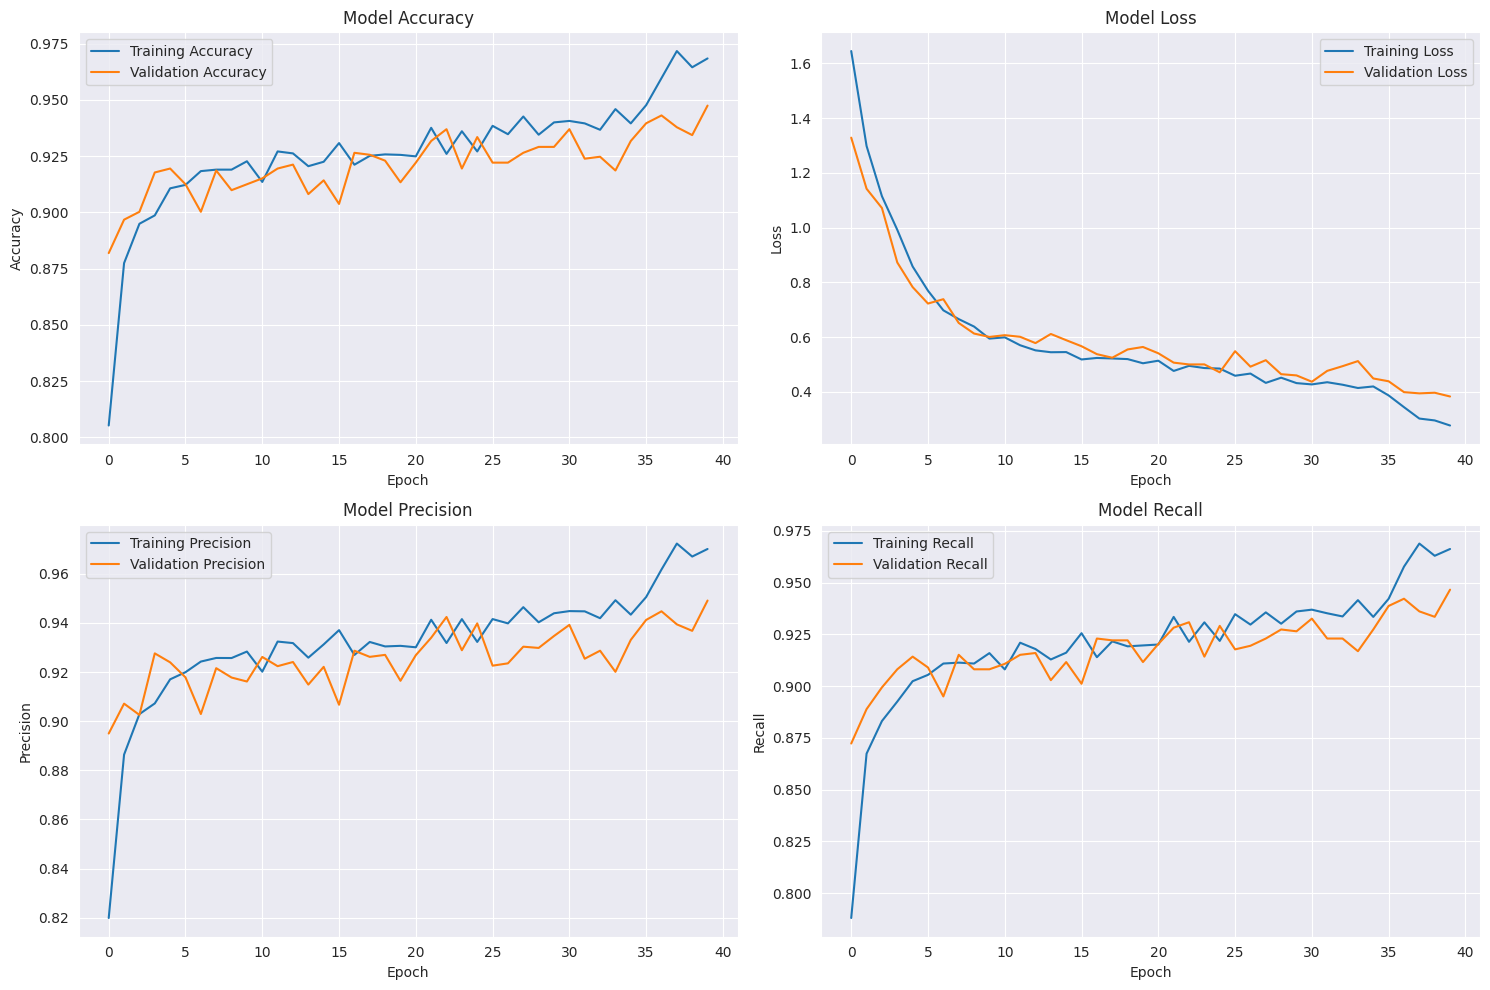

In [19]:
import matplotlib.pyplot as plt

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Loss
axes[0, 1].plot(history.history['loss'], label='Training Loss')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step
Test Accuracy: 93.59%
------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

      glioma     0.9697    0.8533    0.9078       300
  meningioma     0.8440    0.9020    0.8720       306
     notumor     0.9640    0.9926    0.9781       405
   pituitary     0.9670    0.9767    0.9718       300

    accuracy                         0.9359      1311
   macro avg     0.9362    0.9311    0.9324      1311
weighted avg     0.9380    0.9359    0.9358      1311



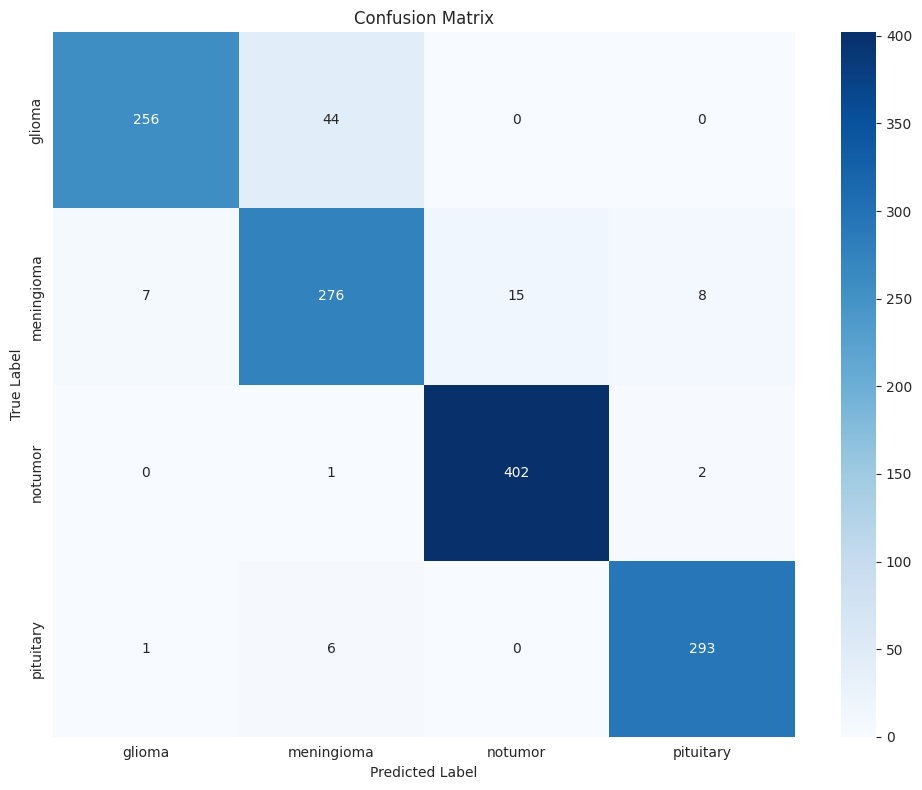

In [ ]:
from sklearn.metrics import accuracy_score

test_gen.reset()

test_predictions = model.predict(test_gen, verbose=1)
test_pred_classes = np.argmax(test_predictions, axis=1)

test_true_classes = test_gen.classes
class_names = list(test_gen.class_indices.keys())

test_accuracy = accuracy_score(test_true_classes, test_pred_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Classification report
print("-"*60)
print("CLASSIFICATION REPORT")
print("-"*60)
print(classification_report(test_true_classes, test_pred_classes, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(test_true_classes, test_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()
